#Predicting Air Quality Index(AQI) With single multivariate Column PM2.5, PM10

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#acessing google drive from google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Dissertation/clean_data.csv')
df

,pubtime,PM2.5,PM10,NO2,O3,CO,SO2,AQI
0,2020-06-30 00:00:00,11.0,23.0,26.0,70.0,0.7,5.0,23.0
1,2020-06-30 01:00:00,14.0,23.0,29.0,54.0,0.8,5.0,23.0
2,2020-06-30 02:00:00,11.0,23.0,31.0,48.0,0.7,5.0,23.0
3,2020-06-30 03:00:00,12.0,25.0,42.0,26.0,0.7,5.0,25.0
4,2020-06-30 04:00:00,7.0,29.0,36.0,22.0,0.7,5.0,29.0
...,...,...,...,...,...,...,...,...
4412,2020-12-30 20:00:00,21.0,59.0,35.0,42.0,0.8,6.0,55.0
4413,2020-12-30 21:00:00,22.0,65.0,35.0,40.0,0.8,6.0,58.0
4414,2020-12-30 22:00:00,26.0,64.0,30.0,43.0,0.8,6.0,57.0
4415,2020-12-30 23:00:00,24.0,58.0,30.0,42.0,0.8,6.0,54.0


#LSTM Model Creation and Training

In [4]:
#Selecting only one column to predict AQI from AQI previous data
df= df[['PM2.5','PM10','AQI']]
df.head()

,PM2.5,PM10,AQI
0,11.0,23.0,23.0
1,14.0,23.0,23.0
2,11.0,23.0,23.0
3,12.0,25.0,25.0
4,7.0,29.0,29.0


In [5]:
#spliting dataset for training and testing phase
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [6]:
#scaling dataset to o and 1 by using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


In [7]:
#Creating input-output pairs by splitting dataset into a sequence of input_size
def create_sequences(data, input_size):
    X, y = [], []
    for i in range(len(data) - input_size):
        X.append(data[i:i + input_size, :])
        y.append(data[i + input_size, -1])
    return np.array(X), np.array(y)

input_size = 24

X_train, y_train = create_sequences(train_scaled, input_size)
X_test, y_test = create_sequences(test_scaled, input_size)

In [8]:
#priniting the shape of x_train and X_test data
print(X_train.shape)
print(X_test.shape)


(3509, 24, 3)
(860, 24, 3)


In [9]:
#creating a LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [10]:
#fitting the model
history = model.fit(X_train, y_train, epochs=50, batch_size=1,validation_split=0.2)

Epoch 1/50
2807/2807 [==============================] - 56s 20ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 2/50
2807/2807 [==============================] - 45s 16ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/50
2807/2807 [==============================] - 48s 17ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 4/50
2807/2807 [==============================] - 47s 17ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 5/50
2807/2807 [==============================] - 44s 16ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 6/50
2807/2807 [==============================] - 46s 17ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 7/50
2807/2807 [==============================] - 46s 16ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 8/50
2807/2807 [==============================] - 48s 17ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 9/50
2807/2807 [==============================] - 45s 16ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/50
2807/2807 [==============================] - 46s 17m

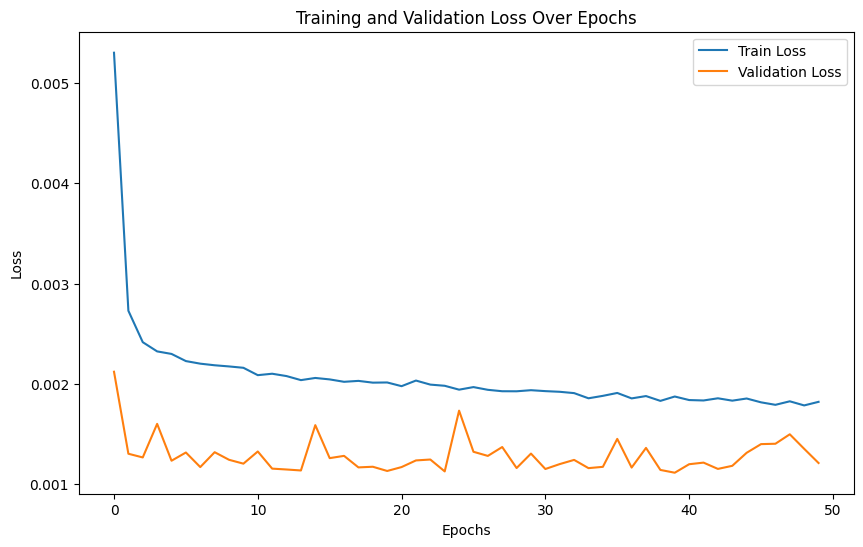

In [11]:
# Plotting the Loss Values of a Fitted Model
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()


In [12]:
#predicting train and test data from x_train and x_test
train_predicted = model.predict(X_train.reshape(X_train.shape))
test_predicted = model.predict(X_test.reshape(X_test.shape))


27/27 [==============================] - 0s 9ms/step


In [13]:
#Repeating three column of same data to inverse it into same shape
train_prediction_copies = np.repeat(train_predicted, 3, axis = -1  )
test_prediction_copies = np.repeat(test_predicted, 3, axis = -1  )
train_actual = np.repeat(y_train, 3, axis = -1  )
test_actual = np.repeat(y_test, 3, axis = -1  )

In [14]:
#Scale back to orginal scale for both train and test predicted data by selecting first colum from repeated cloum
train_predicted=scaler.inverse_transform(np.reshape(train_prediction_copies,(len(train_predicted),3)))[:,0]
test_predicted=scaler.inverse_transform(np.reshape(test_prediction_copies,(len(test_predicted),3)))[:,0]

#Scale back to orginal scale for both train and test actual databy selecting first colum from repeated cloum
train_actual=scaler.inverse_transform(np.reshape(train_actual,(len(X_train),3)))[:,0]
test_actual=scaler.inverse_transform(np.reshape(test_actual,(len(y_test),3)))[:,0]


In [15]:
#creating numpy array data for plotting actual and predicted data
x1 = np.arange(0, len(train_actual))
x2 = np.arange(len(train_actual), len(train_actual)+len(test_actual))

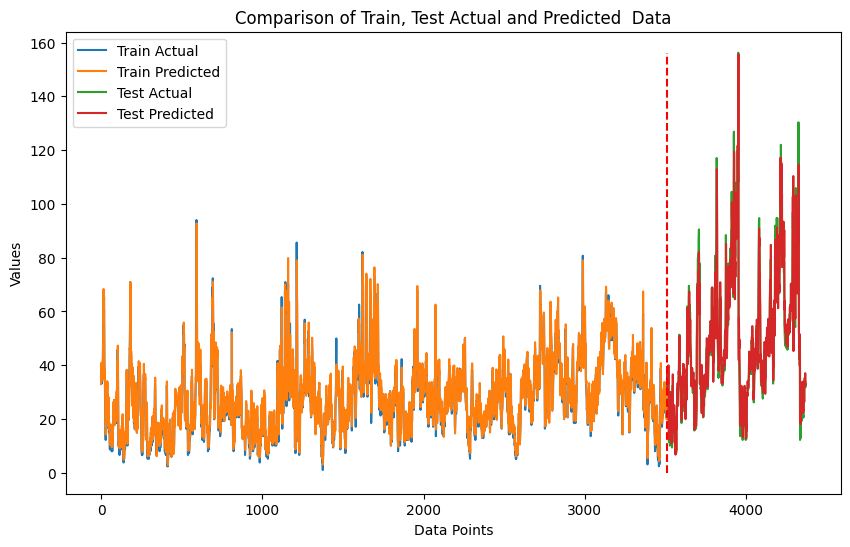

In [16]:
# Plotting Both Train and Test Actual Data
plt.figure(figsize=(10, 6))
plt.plot(x1, train_actual)
plt.plot(x1, train_predicted)
plt.plot(x2, test_actual)
plt.plot(x2, test_predicted)
plt.legend(['Train Actual', 'Train Predicted', 'Test Actual', 'Test Predicted'])
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Comparison of Train, Test Actual and Predicted  Data')
plt.vlines(x=len(train_actual), color='r', linestyles='dashed', ymin=0, ymax=max(test_actual))
plt.show()


In [17]:
#Evulate the model performance

#Mean Squared Error For Testing and Training data
mse_train = mean_squared_error(train_actual, train_predicted)
print("Train Mean Squared Error :", mse_train)
mse_test = mean_squared_error(test_actual, test_predicted)
print("Test Mean Squared Error:", mse_test)

# Root Mean Squared Error For Testing and Training data
rmse_train = np.sqrt(mse_train)
print("Train Root Mean Squared Error:", rmse_train)
rmse_test = np.sqrt(mse_test)
print("Test Root Mean Squared Error:", rmse_test)

#Mean Absolute Error For Testing and Training data
mae_train = mean_absolute_error(train_actual, train_predicted)
print("Train Mean Absolute Error:", mae_train)
mae_test = mean_absolute_error(test_actual, test_predicted)
print("Test Mean Absolute Error:", mae_test)

#R-Sqaured For Testing and Training data
r2_train = r2_score(train_actual, train_predicted)
print("Train R-squared:", r2_train)
r2_test = r2_score(test_actual, test_predicted)
print("Test R-squared:", r2_test)

Train Mean Squared Error : 14.248789615968299
Test Mean Squared Error: 62.09250484686159
Train Root Mean Squared Error: 3.774756894949435
Test Root Mean Squared Error: 7.8798797482488006
Train Mean Absolute Error: 2.62633760204142
Test Mean Absolute Error: 4.93700171425368
Train R-squared: 0.9154247895532461
Test R-squared: 0.9004809352319894
